In [50]:
#Partially Changed Below

curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import ptoc_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor 

suf = params.suf
#mni = load_mni152_brain_mask()

In [70]:
'''exp info'''
#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
exp = ''
control_tasks = ['loc']
file_suf = ''

data_dir = params.data_dir
fig_dir = params.fig_dir
task_info = params.task_info
raw_dir = params.raw_dir

'''scan params'''
tr = 2 #ptoc_params
vols = 184 #ptoc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

'''run info'''
run_num =3
runs = list(range(1,run_num+1))
run_combos = []

In [76]:
import nibabel as nib
import numpy as np

def print_image_stats(file_path, roi_name):
    img = nib.load(file_path)
    data = img.get_fdata()
    print(f"Stats for {roi_name}:")
    print(f"  Shape: {data.shape}")
    print(f"  Min: {np.min(data)}")
    print(f"  Max: {np.max(data)}")
    print(f"  Mean: {np.mean(data)}")
    print(f"  Std: {np.std(data)}")
    print(f"  Non-zero voxels: {np.sum(data != 0)}")

# Use this function for each ROI
ppi_file = f'{out_dir}/{ss}_{rr}_{tsk}_ppi_new.nii.gz'
fc_file = f'{out_dir}/{ss}_{rr}_{tsk}_fc_new.nii.gz'

print_image_stats(ppi_file, 'V1')
print_image_stats(ppi_file, 'aIPS')



Stats for V1:
  Shape: (197, 233, 189)
  Min: -0.1779595662820325
  Max: 0.21456393856708653
  Mean: 0.0020510190638678137
  Std: 0.017153314034416386
  Non-zero voxels: 1882989
Stats for aIPS:
  Shape: (197, 233, 189)
  Min: -0.1779595662820325
  Max: 0.21456393856708653
  Mean: 0.0020510190638678137
  Std: 0.017153314034416386
  Non-zero voxels: 1882989


Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-025/ses-01/derivatives/fc/sub-025_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-038/ses-01/derivatives/fc/sub-038_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-057/ses-01/derivatives/fc/sub-057_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-059/ses-01/derivatives/fc/sub-059_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-064/ses-01/derivatives/fc/sub-064_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-067/ses-01/derivatives/fc/sub-067_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-068/ses-01/derivatives/fc/sub-068_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-071/ses-01/derivatives/fc/sub-071_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrmannlab/vlad/ptoc/sub-083/ses-01/derivatives/fc/sub-083_V1_loc_fc.nii.gz
Loading image from: /lab_data/behrman

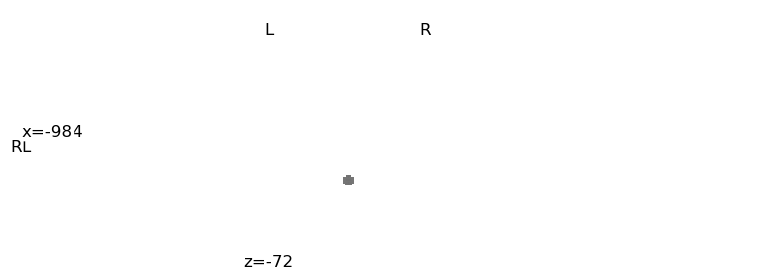

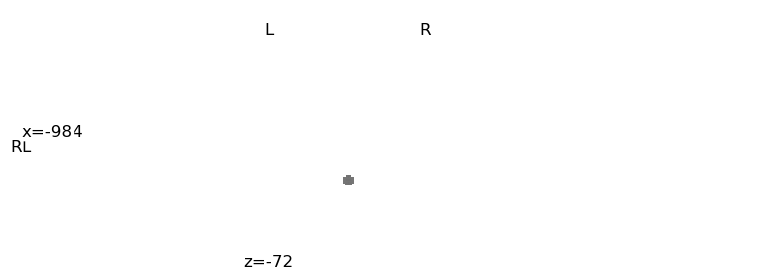

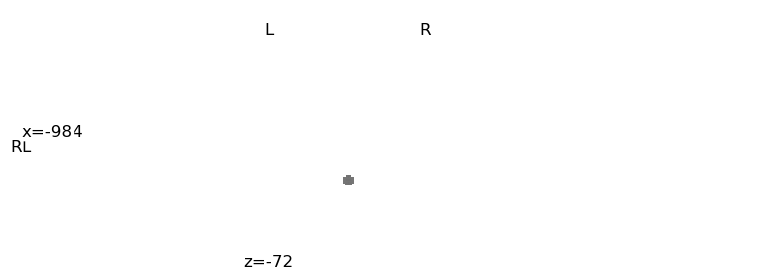

In [21]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting, glm

# Initialize second-level model with smoothing
second_level_model = glm.second_level.SecondLevelModel(smoothing_fwhm=4)
alpha = .05
rois = ['V1', 'LO', 'aIPS']

for rr in rois:
    ppi_img = []
    
    for ss in subs:
        sub_dir = f'{study_dir}/{ss}/ses-01/'  # study is PTOC
        out_dir = f'{study_dir}/{ss}/ses-01/derivatives/fc' # PTOC

        curr_img_path = f'{out_dir}/{ss}_{rr}_loc_fc.nii.gz'
        if os.path.exists(curr_img_path):
            print(f'Loading image from: {curr_img_path}')
            curr_img = image.load_img(curr_img_path)
            
            # Standardize the image
            standardized_img = image.math_img("(img - np.mean(img))/np.std(img)", img=curr_img)
            
            # Collect standardized images for group analysis
            ppi_img.append(standardized_img)
        else:
            print(f'File not found: {curr_img_path}')
    
    if ppi_img:
        # Save the group-level standardized images
        group_standardized_img_path = f'/user_data/csimmon2/git_repos/ptoc/results/PPI'
        print(f'Saving group standardized images to: {group_standardized_img_path}')
        nib.save(image.concat_imgs(ppi_img), group_standardized_img_path)
        
        # Perform group-level smoothing
        print(f'Smoothing images for ROI: {rr}')
        smoothed_img = image.smooth_img(image.concat_imgs(ppi_img), 6)
        
        # Compute the mean image
        final_img = image.mean_img(smoothed_img)
        print(f'Computed mean image for ROI: {rr}')
        
        # Define the design matrix for second-level model
        design_matrix = pd.DataFrame([1] * len(ppi_img), columns=['intercept'])
        
        # Fit the second-level model
        second_level_model = second_level_model.fit(ppi_img, design_matrix=design_matrix)
        z_map = second_level_model.compute_contrast(output_type='z_score')

        # Threshold the results
        thresh_val = glm.threshold_stats_img(z_map, alpha=alpha, height_control='fdr', mask_img=whole_brain_mask)
        thresh_img_path = f'{results_dir}/PPI/{rr}_ppi_stand.nii.gz'
        print(f'Saving thresholded image to: {thresh_img_path}')
        nib.save(thresh_val[0], thresh_img_path)
        print(f'{rr} threshold value: {thresh_val[1]}')
        plotting.plot_stat_map(thresh_val[0])
    else:
        print(f'No valid images found for ROI: {rr}')


V1 3.186749785922414
LO 3.186749785922414
aIPS 3.186749785922414


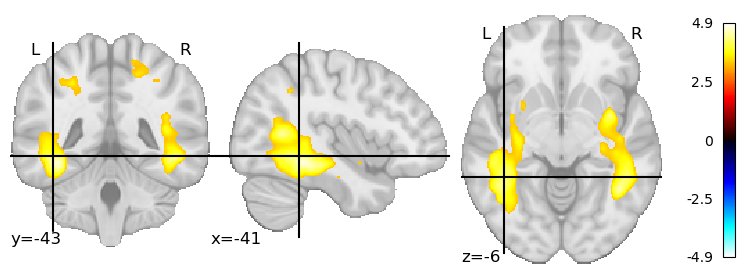

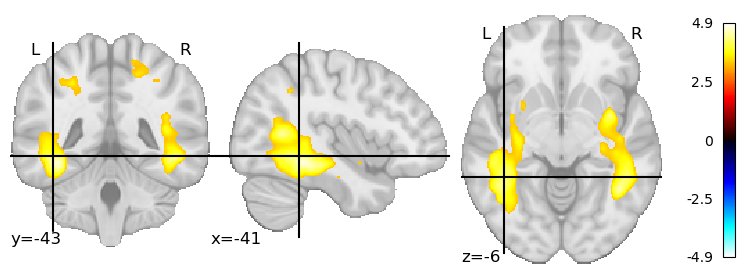

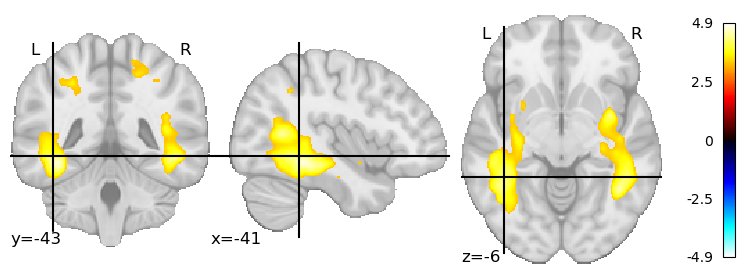

In [18]:
"""
run 2nd level model on each first level
"""
second_level_model = glm.second_level.SecondLevelModel(smoothing_fwhm=4)
alpha = .05
rois = ['V1', 'LO', 'aIPS']

for rr in rois:
    ppi_img = []
    for ss in subs:
                
        sub_dir = f'{study_dir}/{ss}/ses-01/'  # study is PTOC
        roi_dir = f'{sub_dir}/derivatives/rois'  # rois in PTOC
        raw_dir = params.raw_dir  # hemispace
        temp_dir = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc'  # hemispace
        out_dir = f'{study_dir}/{ss}/ses-01/derivatives/fc' #PTOC

        #if os.path.exists(f'{roi_dir}/{rr}_peak.nii.gz'):
        curr_img = image.load_img(f'{out_dir}/{ss}_{rr}_loc_fc.nii.gz')

        curr_img = image.math_img("(img - np.mean(img))/np.std(img)", img=curr_img)
        nib.save(curr_img, f'{out_dir}/{ss}_{rr}_ppi_stand.nii.gz')
        
        ppi_img.append(curr_img)

    ppi_img = image.smooth_img(ppi_img, 6)
    final_img = image.mean_img(ppi_img)
    
    design_matrix = pd.DataFrame([1] * len(ppi_img),
                            columns=['intercept'])
    final_img= second_level_model.fit(ppi_img, design_matrix= design_matrix)
    z_map = final_img.compute_contrast(output_type='z_score')

    thresh_val = glm.threshold_stats_img(z_map,alpha=alpha,height_control='fdr', mask_img= whole_brain_mask)
    
    nib.save(thresh_val[0], f'{results_dir}/PPI/{rr}_ppi_stand.nii.gz')
    print(f'{rr}', thresh_val[1])
    plotting.plot_stat_map(thresh_val[0])
    


In [36]:
# Calculate mean and standard deviation of FC and PPI within the ROI
fc_mean = np.mean(fc_data)
ppi_mean = np.mean(ppi_data)
fc_std = np.std(fc_data)
ppi_std = np.std(ppi_data)

print(f'FC Mean: {fc_mean}, FC Std: {fc_std}')
print(f'PPI Mean: {ppi_mean}, PPI Std: {ppi_std}')


FC Mean: 0.0012847712823515478, FC Std: 0.017990930812178924
PPI Mean: 0.0001412672245597026, PPI Std: 0.007083225059789107


T-statistic: 169.90409948585338
P-value: 0.0


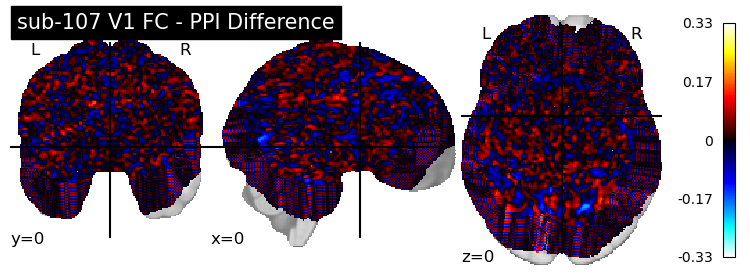

In [37]:
import numpy as np
from scipy.stats import ttest_rel
rr = 'V1'

# Load the images as numpy arrays
fc_data = fc_img.get_fdata()
ppi_data = ppi_img.get_fdata()

# Ensure the data shapes match
assert fc_data.shape == ppi_data.shape, "FC and PPI data shapes do not match"

# Calculate the difference
diff_data = fc_data - ppi_data

# Perform a paired t-test across all voxels
t_stat, p_values = ttest_rel(fc_data, ppi_data, axis=None)

# Print out some basic statistics
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_values}')

# Visualize the difference map
diff_img = image.new_img_like(fc_img, diff_data)
plotting.plot_stat_map(diff_img, title=f'{ss} {rr} FC - PPI Difference', cut_coords=(0, 0, 0))
plotting.show()


T-statistic: 169.90409948585338
P-value: 0.0


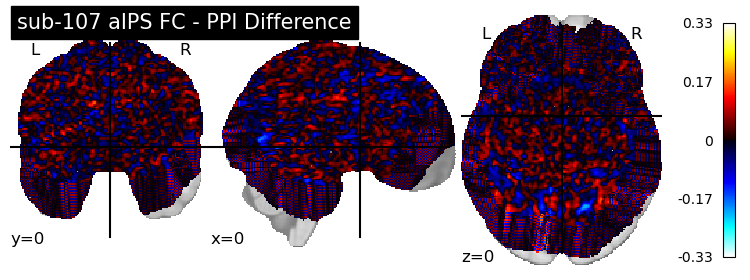

In [35]:
import numpy as np
from scipy.stats import ttest_rel

# Load the images as numpy arrays
fc_data = fc_img.get_fdata()
ppi_data = ppi_img.get_fdata()

# Ensure the data shapes match
assert fc_data.shape == ppi_data.shape, "FC and PPI data shapes do not match"

# Calculate the difference
diff_data = fc_data - ppi_data

# Perform a paired t-test across all voxels
t_stat, p_values = ttest_rel(fc_data, ppi_data, axis=None)

# Print out some basic statistics
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_values}')

# Visualize the difference map
diff_img = image.new_img_like(fc_img, diff_data)
plotting.plot_stat_map(diff_img, title=f'{ss} {rr} FC - PPI Difference', cut_coords=(0, 0, 0))
plotting.show()


In [ ]:
from nilearn import plotting, image
import nibabel as nib

# Example paths to the saved FC images for different ROIs for the same subject
roi_list = ['LO', 'V1', 'aIPS']
fc_images = {}

for roi in roi_list:
    fc_image_path = f'{out_dir}/{ss}_{rr}_{tsk}_ppi.nii.gz'
    fc_images[roi] = image.load_img(fc_image_path)

# Display the images side by side with an increased threshold
threshold_value = 3.0  # You can adjust this value as needed
for roi, img in fc_images.items():
    plotting.plot_stat_map(img, title=f'sub-095 {roi} FC', cut_coords=(0, 0, 0), threshold=threshold_value)

plotting.show()


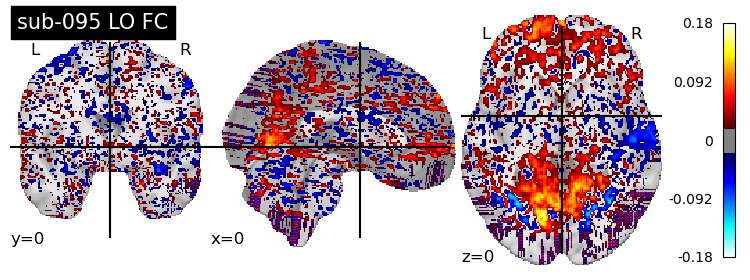

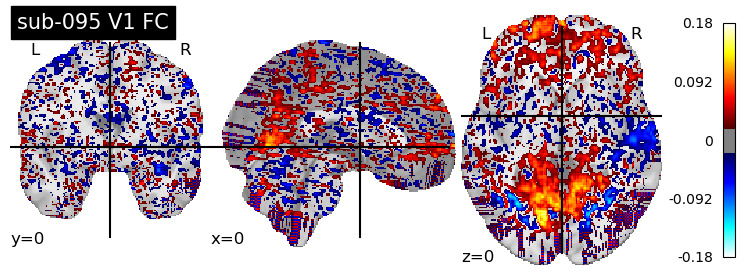

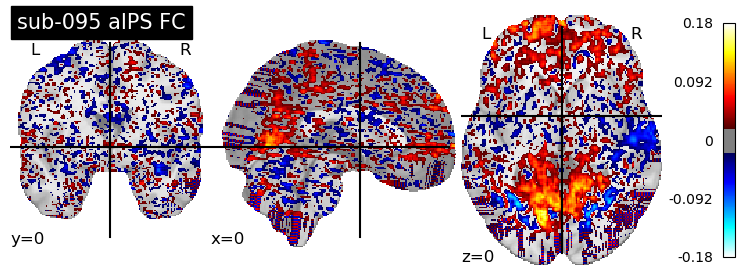

In [74]:
from nilearn import plotting, image
import nibabel as nib

# Example paths to the saved FC images for different ROIs for the same subject
roi_list = ['LO', 'V1', 'aIPS']
fc_images = {}

for roi in roi_list:
    fc_image_path = f'{out_dir}/{ss}_{rr}_{tsk}_ppi.nii.gz'
    fc_images[roi] = image.load_img(fc_image_path)

# Display the images side by side
threshold_value = 0.02  # You can adjust this value as needed
for roi, img in fc_images.items():
    plotting.plot_stat_map(img, title=f'sub-095 {roi} FC', cut_coords=(0, 0, 0), threshold=threshold_value)

plotting.show()


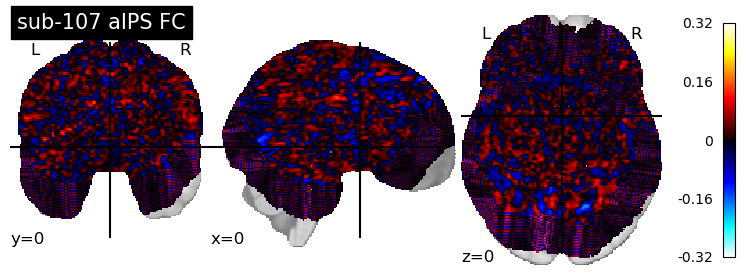

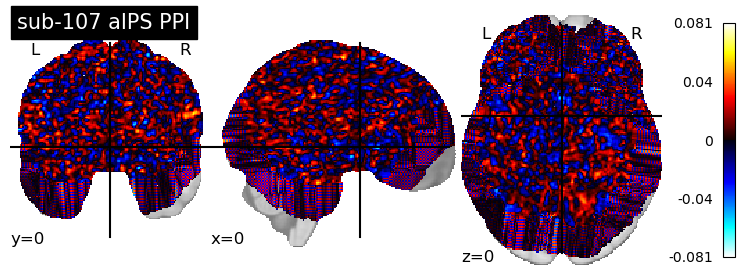

In [34]:
from nilearn import plotting

tsk = 'loc'

# Example paths to the saved FC and PPI images for a specific ROI
fc_image_path = f'{out_dir}/{ss}_{rr}_{tsk}_fc.nii.gz'
ppi_image_path = f'{out_dir}/{ss}_{rr}_{tsk}_ppi.nii.gz'

# Load the images
fc_img = image.load_img(fc_image_path)
ppi_img = image.load_img(ppi_image_path)

# Display the images side by side
plotting.plot_stat_map(fc_img, title=f'{ss} {rr} FC', cut_coords=(0, 0, 0))
plotting.plot_stat_map(ppi_img, title=f'{ss} {rr} PPI', cut_coords=(0, 0, 0))
plotting.show()


aIPS inf


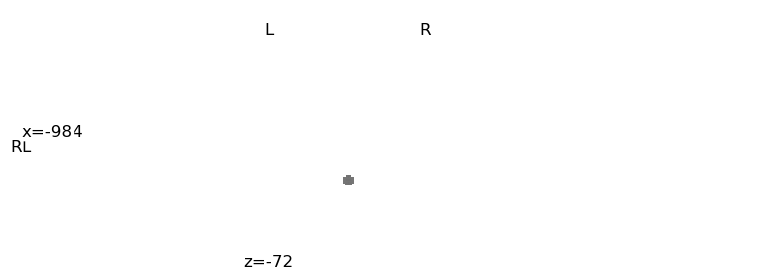

In [32]:
"""
run 2nd level model on each first level
"""
second_level_model = glm.second_level.SecondLevelModel(smoothing_fwhm=4)
alpha = .05
rois = ['aIPS']

for rr in rois:
    ppi_img = []
    for ss in subs:
        
        out_dir = f'{study_dir}/{ss}/ses-01/derivatives/fc' # PTOC
        #if os.path.exists(f'{roi_dir}/{roi}_peak.nii.gz'):
        curr_img = image.load_img(f'{out_dir}/{ss}_{rr}_loc_fc.nii.gz')

        curr_img = image.math_img("(img - np.mean(img))/np.std(img)", img=curr_img)
       # nib.save(curr_img, f'{out_dir}/{ss}_{rr}_ppi_stand.nii.gz')
        
        ppi_img.append(curr_img)

    #ppi_img = image.smooth_img(ppi_img, 6)
    #final_img = image.mean_img(ppi_img)
    design_matrix = pd.DataFrame([1] * len(ppi_img),
                            columns=['intercept'])
    final_img= second_level_model.fit(ppi_img, design_matrix= design_matrix)
    z_map = final_img.compute_contrast(output_type='z_score')

    thresh_val = glm.threshold_stats_img(z_map,alpha=alpha,height_control='fdr', mask_img= whole_brain_mask)
    
    #nib.save(thresh_val[0], f'{results_dir}/ppi/{rr}_ppi_stand.nii.gz')
    print(f'{rr}', thresh_val[1])
    plotting.plot_stat_map(thresh_val[0])

In [7]:
thresh_val[1]

inf

lLO_toolloc
lLO_toolloc


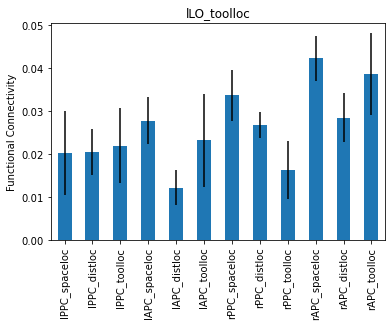

lPFS_toolloc
lPFS_toolloc


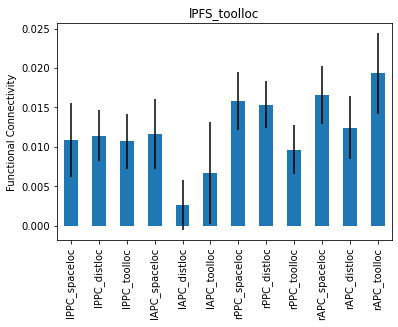

rLO_toolloc
rLO_toolloc


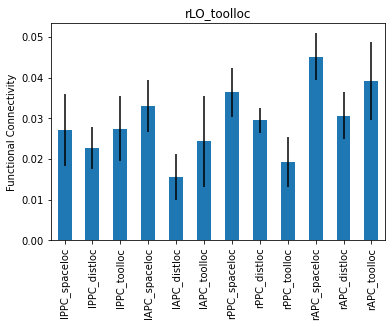

rPFS_toolloc
rPFS_toolloc


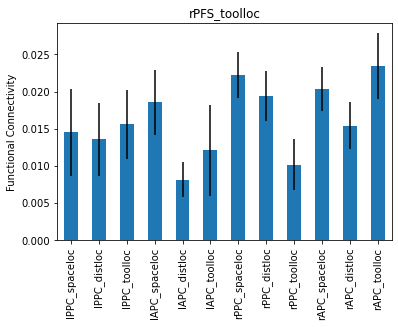

In [4]:
"""
extract avg PPI in LO, aIPS, V1
"""

ventral_rois = ['LO_toolloc']
rois = ["PPC_spaceloc", "PPC_distloc", "APC_spaceloc", "APC_distloc"]

#For each ventral ROI
    
for vr in ventral_rois:
    
    #summary_df = pd.DataFrame(columns = ['sub'] + ['l' + rr for rr in rois] + ['r' + rr for rr in rois])
    summary_df = pd.DataFrame(columns = ['sub'] + [rr for rr in rois])
    ventral = f'{vr}'
    print(ventral)
    
    for ss in subs:
        sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
        roi_dir = f'{sub_dir}/derivatives/rois'
        
        if os.path.exists(f'{roi_dir}/spheres/{ventral}_sphere.nii.gz'):
            ventral_mask = image.load_img(f'{roi_dir}/spheres/{ventral}_sphere.nii.gz')
            ventral_mask = input_data.NiftiMasker(ventral_mask)
            
            roi_mean = []
            roi_mean.append(ss)
            #For each dorsal ROI
            for lr in ['l', 'r']:
                for rr in rois:
                    roi = f'{lr}{rr}'
                    #if os.path.exists(f'{roi_dir}/{roi}_peak.nii.gz'):
                    ppi_img = image.load_img(f'{out_dir}/{study}{ss}_{roi}_ppi_stand.nii.gz')
                    #ppi_img  = image.smooth_img(ppi_img, 6)
                    acts = ventral_mask.fit_transform(ppi_img)

                        
                    roi_mean.append(acts.mean())
                    #else:
                    #    roi_mean.append(np.nan)
            
            summary_df = summary_df.append(pd.Series(roi_mean, index = summary_df.columns), ignore_index = True)
    print(ventral)
    summary_df.to_csv(f'{results_dir}/{ventral}_fc.csv', index=False)
    summary_df.iloc[:, 1:].mean().plot(kind = 'bar', title = ventral, ylabel = 'Functional Connectivity',
    yerr=[summary_df.iloc[:,1:].sem().to_list(), summary_df.iloc[:,1:].sem().to_list()])
    plt.pause(0.0001)
            




# print(ss, roi)

In [16]:
"""
Compute bootstrap CIs for FC between spaceloc and every roi
"""

ventral_rois = ['LO_toolloc', 'PFS_toolloc']
contrasts = [['rPPC_spaceloc', 'lPPC_toolloc'],['rPPC_spaceloc', 'lAPC_toolloc'], ['rAPC_spaceloc', 'lAPC_toolloc']]
iter = 5000
perm_summary = pd.DataFrame(columns = ['ventral', 'seed1','seed2', 'ci_low', 'ci_high'])
for lr in ['l','r']:
    for vr in ventral_rois:
        df = pd.read_csv(f'{results_dir}/{lr}{vr}_fc.csv')    
        boot_vals = np.zeros((len(contrasts), iter))
        for ii in range(0,iter):
            temp_df = df.sample(len(df), replace = True)
            for cont_n, cont in enumerate(contrasts):
                boot_vals[cont_n, ii] = (temp_df[cont[0]].mean() - temp_df[cont[1]].mean())/ np.mean([np.std(temp_df[cont[0]]),np.std(temp_df[cont[1]])])
                #pdb.set_trace()


        for cont_n, cont in enumerate(contrasts):
            ci_low = np.percentile(boot_vals[cont_n], alpha*100)
            ci_high= np.percentile(boot_vals[cont_n], 100-alpha*100)

            data_row = pd.Series([f'{lr}{vr}', cont[0], cont[1],ci_low, ci_high], index=perm_summary.columns)
            perm_summary = perm_summary.append(data_row,ignore_index=True)

        #pdb.set_trace()

In [15]:
perm_summary

,ventral,seed1,seed2,ci_low,ci_high
0,lLO_toolloc,rPPC_spaceloc,lPPC_toolloc,-0.188267,1.203690
1,lLO_toolloc,rAPC_spaceloc,lAPC_toolloc,0.135171,1.454359
2,lPFS_toolloc,rPPC_spaceloc,lPPC_toolloc,-0.162605,1.208981
3,lPFS_toolloc,rAPC_spaceloc,lAPC_toolloc,0.039543,1.170276
4,rLO_toolloc,rPPC_spaceloc,lPPC_toolloc,-0.201976,1.066534
5,rLO_toolloc,rAPC_spaceloc,lAPC_toolloc,0.198825,1.495103
6,rPFS_toolloc,rPPC_spaceloc,lPPC_toolloc,-0.143206,1.195301
7,rPFS_toolloc,rAPC_spaceloc,lAPC_toolloc,-0.010428,1.157120


In [10]:
summary_df

,sub,rPPC_spaceloc,rPPC_distloc,rPPC_toolloc,rAPC_spaceloc,rAPC_distloc,rAPC_toolloc


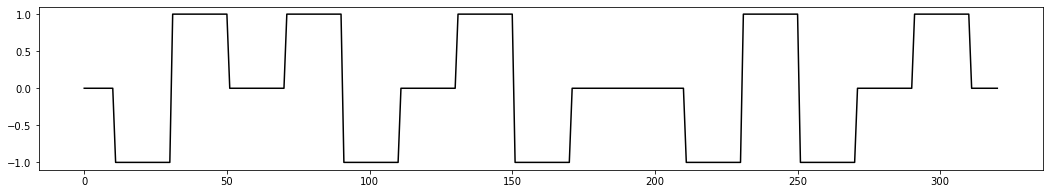

In [22]:
plt.figure(figsize=(18, 3))
plt.plot(psy, color = 'black')
plt.show()



In [ ]:
"""
create average
"""

for lr in ['r']:
    for rr in rois:
        roi = f'{lr}{rr}'
        print(roi)
        mean_ppi = []
        for ss in subs:
            sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
            roi_dir = f'{sub_dir}/derivatives/rois'
            
            if os.path.exists(f'{roi_dir}/{roi}_peak.nii.gz'):
                ppi_img = image.load_img(f'{out_dir}/sub-{study}{ss}_{roi}_fc.nii.gz') #load image
                affine = ppi_img.affine #get affine transforms
                #ppi_img = np.arctanh(image.get_data(ppi_img))  #get image and fisher z it
                
                #ppi_img= (ppi_img-np.mean(ppi_img))/np.std(ppi_img)
                
                mean_ppi.append(ppi_img) #convert back to nifti
                
            
        mean_ppi=image.mean_img(mean_ppi)
        mean_ppi = image.math_img("(img - np.mean(img))/np.std(img)", img=mean_ppi)
        #find fdr-corrected threshold
        thresh_val = glm.threshold_stats_img(mean_ppi,alpha=.05,  height_control='fdr', cluster_threshold = 5, two_sided = False)
        thresh_img = image.threshold_img(mean_ppi, thresh_val[1])
        plotting.plot_glass_brain(thresh_img,  draw_cross = False,threshold = 3.1, colorbar = True)
        plt.pause(0.0001)
                
                
                
                
                
                
                
                

In [ ]:
mean_ppi

In [ ]:
ss = 1001
roi = 'rPPC_spaceloc'
rn = 1
roi_mask = image.load_img(f'{roi_dir}/{roi}_peak.nii.gz')
psy = make_psy_cov(rn)
img4d, phys = load_filtered_func(rn)


In [ ]:
curr_cov = curr_cov.iloc[:,0:3]
curr_cov = curr_cov.to_numpy()
            
psy, name = glm.first_level.compute_regressor(curr_cov.T, 'spm', times)

In [ ]:
phys_z = (phys - np.mean(phys)) / np.std(phys)

plt.plot(phys_z)
plt.plot(psy)
plt.plot(ppi)
ppi = psy*phys_z


In [ ]:
plt.plot(ppi)
plt.plot(psy)

In [ ]:
#pad = np.zeros((int(4/tr),2))
#psy = np.vstack([pad, psy])
#psy = psy[:vols, 1]
#ppi = psy
brain_time_series = brain_masker.fit_transform(img4d)

#Correlate interaction term to TS for vox in the brain
seed_to_voxel_correlations = (np.dot(brain_time_series.T, ppi) /
                  ppi.shape[0])

#transform correlation map back to brain
seed_to_voxel_correlations_img = brain_masker.inverse_transform(seed_to_voxel_correlations.T)
print(seed_to_voxel_correlations.shape)
print(seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max())

In [ ]:
cov

In [ ]:

plotting.view_img(seed_to_voxel_correlations_img, threshold = .1)

In [ ]:
psy


In [ ]:
psy.shape

In [ ]:
"""
Create behavioral covariate
with contrasting 1/-1 conditions
"""


#runs = [1]
#Load covs for each run
for rn_n,rn in enumerate(runs):
    print(rn)
    #postive cov
    curr_cov = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{rn}_SA.txt', sep = '\t', header = None, names = ['onset','duration', 'value'])
    #contrasting (neg) cov
    curr_cont = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{rn}_FT.txt', sep = '\t', header =None, names =['onset','duration', 'value'])
    curr_cont.iloc[:,2] = curr_cont.iloc[:,2] *-1 #make contrasting cov neg
    
    curr_cov = curr_cov.append(curr_cont) #append to positive
    #add number of vols to the timing cols based on what run you are on
    #e.g., for run 1, add 0, for run 2, add 321
    curr_cov['onset'] = curr_cov['onset'] + ((rn_n)*vols) 
    #pdb.set_trace()
    
    #append to concatenated cov
    if rn_n ==0 :
        cov = curr_cov
    else:
        cov = cov.append(curr_cov)

#create offsett
cov['offset'] = cov['onset'] + cov['duration']
cov[['onset', 'offset']] = np.round(cov[['onset', 'offset']])
    
#sort by onset    
cov = cov.sort_values(by='onset')

#Convert cov into a continuous predictor with a value for every time point
psy = np.zeros((vols*rn,2)) #make zero with the length of all runs puttogether
psy[:,0] = list(range(1,vols*rn+1))

for ii in cov_ts[:,0]:
    ii =int(ii)
    try:
        psy[ii,1] = cov['value'][(ii >= np.round(cov['onset'])) & (ii < (np.round(cov['offset'])))].to_list()[0]
    except:
        pass

In [ ]:
"""
load filtered func data from all runs
"""
runs = [1]
all_nii = []
for rn in runs:
    print(rn)
    curr_img = image.load_img(f'{exp_dir}/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz')
    curr_img = image.clean_img(curr_img,standardize=True, t_r=1)
    all_nii.append(curr_img)

#img4d = image.concat_imgs(all_nii) #compile into 4D

img4d = image.resample_to_img(curr_img,mni)


#run_img = load_img(f'{exp_dir}/run-01/1stLevel.feat/filtered_func_data.nii.gz')

In [ ]:

roi_data = pd.read_csv(f'{roi_dir}/data/{rr}.txt',  sep="  ", header = None, names = ['x','y', 'z', 'value'])
roi_data = roi_data.sort_values(by = 'value',ascending = False).reset_index()
roi_mask = image.load_img(f'{roi_dir}/{rr}_peak.nii.gz')

In [ ]:
first_vol = image.index_img(curr_img,0)
plotting.plot_stat_map(first_vol, threshold = 1)

In [ ]:
plotting.plot_roi(roi_mask, bg_img = mni)

In [ ]:
roi_masker = input_data.NiftiMasker(roi_mask)
seed_time_series = roi_masker.fit_transform(img4d)

In [ ]:
phys = np.mean(seed_time_series, axis= 1)
phys = avg_ts.reshape((phys.shape[0],1))

In [ ]:
HRF_COV = hrf(psy[:,1], 1)
plt.plot(HRF_COV)
psy.shape

In [ ]:
times = np.arange(0, vols, 1)
test = cov.iloc[:,:3].to_numpy()

signal, name = glm.first_level.compute_regressor(test.T, 'spm', times)


In [ ]:
plt.plot(signal)
len(signal)

In [ ]:
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

In [ ]:
exp_condition

In [ ]:
seed_to_voxel_correlations = (np.dot(brain_time_series.T, ppi) /
                              avg_ts.shape[0]
                              )
print(seed_to_voxel_correlations.shape)
print(seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max())

In [ ]:
from nilearn import plotting

seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
                                 threshold=0.1, vmax=1,
                                 cut_coords=roi_coords[0],
                                 title="Seed-to-voxel correlation"
                                 )
#display.add_markers(marker_coords=roi_coords, marker_color='g',
#                    marker_size=300)

In [ ]:
test = []
test.append(seed_to_voxel_correlations_img)
test.append(seed_to_voxel_correlations_img)

In [ ]:
test_mean = image.mean_img(test)
test_mean.shape

In [ ]:
plotting.view_img(seed_to_voxel_correlations_img, threshold = .1)

In [ ]:
roi_mask = image.load_img(f'{roi_dir}/rPPC_spaceloc.nii.gz')
plotting.plot_roi(roi_mask, bg_img = seed_to_voxel_correlations_img)

In [ ]:
from nilearn import datasets

dataset = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dataset.func[0]
confound_filename = dataset.confounds[0]

In [ ]:
confounds = pd.read_csv(confound_filename, sep = '\t')

In [ ]:
confounds

In [ ]:
"""
Extract timeseries from peak voxel of ROI
"""


roi_coords = [tuple(roi_data[['x','y','z']].iloc[0].to_list())]

seed_masker = input_data.NiftiSpheresMasker(
    roi_coords, radius=8)

seed_time_series = seed_masker.fit_transform(img4d)
brain_time_series = brain_masker.fit_transform(img4d)

In [ ]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])